In [ ]:
import torch
import torch.nn as nn
import os
import pandas as pd
import random
import numpy as np
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [ ]:
# game_data = pd.read_csv('drive/MyDrive/games.csv')
# bat_data = pd.read_csv('drive/MyDrive/batting_data.csv')
# pitch_data = pd.read_csv('drive/MyDrive/pitching_data.csv')

game_data = pd.concat([
    pd.read_csv('drive/MyDrive/games.csv'),
    pd.read_csv('drive/MyDrive/gl2022.csv', header=None, names=[str(i+1) for i in range(161)]),
    pd.read_csv('drive/MyDrive/gl2021.csv', header=None, names=[str(i+1) for i in range(161)]),
    pd.read_csv('drive/MyDrive/gl2020.csv', header=None, names=[str(i+1) for i in range(161)]),
    pd.read_csv('drive/MyDrive/gl2019.csv', header=None, names=[str(i+1) for i in range(161)])
], axis = 0)
bat_data = pd.read_csv('drive/MyDrive/curr_batting.csv')#bat_car.csv')#drive/MyDrive/Splits Leaderboard Data Batting 1st Batting 3rd Batting 2nd Batting 4th Batting 5th Batting 6th 1st Inning.csv')
pitch_data = pd.read_csv('drive/MyDrive/curr_pitching.csv')#drive/MyDrive/Splits Leaderboard Data 1st Inning 1st Time Through Order as SP.csv')

In [ ]:
max_pitch_values = []
for col in pitch_data.iloc[:, 4:-1].columns:
  max_pitch_values.append(pitch_data[col].max())

max_bat_values = []
for col in bat_data.iloc[:, 4:-1].columns:
  max_bat_values.append(bat_data[col].max())

# max_pitch_values = pd.DataFrame(np.array(max_pitch_values))#, columns=pitch_data.iloc[:, 3:-1].columns)
print(max_pitch_values)
print(max_bat_values)
print(len(max_bat_values), len(max_pitch_values))


[700, 135.00000135, 195, 38, 6, 110, 104, 32, 73, 3, 23, 190, 0.8, 0.888888888, 2.0, 1.1111594835917156]
[776, 694, 211, 128, 48, 8, 49, 145, 126, 140, 3, 188, 17, 11, 5, 26, 52, 21, 1.0]
19 16


In [ ]:
print(pitch_data.columns)

Index(['Season', 'Name', 'Tm', 'G', 'TBF', 'ERA', 'H', '2B', '3B', 'R', 'ER',
       'HR', 'BB', 'IBB', 'HBP', 'SO', 'AVG', 'OBP', 'SLG', 'wOBA',
       'playerId'],
      dtype='object')


In [ ]:
num_nrfi = 0
num_nn = 0
for game in game_data.itertuples():
  box_scoresHA = [game[21], game[20]]
  nrfi = 1
  for i in box_scoresHA:
    if i == '0' or i == 0:
      continue
    if i[0]== '0':
      continue
    elif i[0]=='(':
      nrfi = 0
      continue
    elif int(i[0]) > 0:
      nrfi = 0

  if nrfi == 1:
    num_nrfi +=1
  else:
    num_nn+=1
# print(num_nrfi, num_nn)

In [ ]:
train_data = []
train_labels = []
test_data = []
test_labels = []
no_bat_data = []
no_pitch_data = []
bad_pitch = 0
bad_bat = 0
good_games = 0
total_game = 0
for game in game_data.itertuples():
  good_game = True
  game_state_row = []
  pitcher_namesHA = [game[105], game[103]]
  for pitcher in pitcher_namesHA:
    pitcher_names = [pitcher, pitcher + ' Jr.', pitcher + ' II', pitcher + ' III', ]
    pitch_data_row = pitch_data[pitch_data['Name'].isin(pitcher_names)]
    if pitch_data_row.empty:
      good_game = False
      if pitcher not in no_pitch_data:
        print(f'Error: No data found for pitcher {pitcher}. Skipping...')
        no_pitch_data.append(pitcher)
      bad_pitch +=1
      break
    tbf = pitch_data_row['TBF'].max()
    pitch_data_row = pitch_data_row.iloc[:, 5:-1]
    val = 0
    # print('ppppppp    ', len(pitch_data_row))
    norm_list = ['TBF', 'ERA', 'H', '2B', '3B', 'R', 'ER',
       'HR', 'BB', 'IBB', 'HBP', 'SO']
    for i in pitch_data_row:
      # print(i)
      if i in norm_list:
        game_state_row.append((pitch_data_row[i].sum() / len(pitch_data_row)) / tbf)# / max_pitch_values[val])
      else:
        game_state_row.append((pitch_data_row[i].sum() / len(pitch_data_row)))
      val +=1
  batter_namesHA = []
  for i in range(6):
    batter_namesHA.append(game[134 + i*3])
  for i in range(6):
    batter_namesHA.append(game[107 + i*3])
  for batter in batter_namesHA:
    batter_names = [batter, batter + ' Jr.', batter + ' II', batter + ' III', ]
    bat_data_row = bat_data[bat_data['Name'].isin(batter_names)]#bat_data['Name'],batter)]
    if bat_data_row.empty:
      good_game = False
      if batter not in no_bat_data:
        print(f'Error: No data found for batter {batter}. Skipping...')
        no_bat_data.append(batter)
      bad_bat+=1
      break
    # else:
    tpa = bat_data_row['PA'].max()
    # print(bat_data_row)
    # print(tpa.max())
    # break
    bat_data_row = bat_data_row.iloc[:, 5:-1]
    col = 0
    val = 0
    # print(bat_data_row.shape)
    # print('tttttt     ',   len(bat_data_row))
    # batter_PA = bat_data_row['PA']
    # norm_llist = ''
    for i in bat_data_row:
      col+=1
      if i != 'AVG':
        game_state_row.append((bat_data_row[i].sum() / len(bat_data_row))/ tpa)# / max_bat_values[val])
      else:
        game_state_row.append((bat_data_row[i].sum() / len(bat_data_row)))
      val += 1
  box_scoresHA = [game[21], game[20]]
  nrfi = 1
  for i in box_scoresHA:
    if i == '0' or i == 0:
      continue
    if i[0]== '0':
      continue
    elif i[0]=='(':
      nrfi = 0
      continue
    elif int(i[0]) > 0:
      nrfi = 0
    else:
      print('!!!NRFI error!!!')
      print(i)
      quit()
      break
  total_game +=1
  # print(len(game_state_row))

  if good_game and len(game_state_row) == 246:
    good_games +=1
    if random.random() < .1:
      test_data.append(game_state_row)
      test_labels.append(nrfi)
      # if nrfi==1 and random.random() < .3:
      #   test_data.append(game_state_row)
      #   test_labels.append(nrfi)
    else:
      train_data.append(game_state_row)
      train_labels.append(nrfi)
      # if nrfi==1 and random.random() < .3:
      #   train_data.append(game_state_row)
      #   train_labels.append(nrfi)
  # else:
  #   print('bad data')

Error: No data found for batter Michael Brosseau. Skipping...
Error: No data found for pitcher Vincent Velasquez. Skipping...
Error: No data found for batter Ji-Man Choi. Skipping...
Error: No data found for batter Yulieski Gurriel. Skipping...
Error: No data found for pitcher Matt Boyd. Skipping...
Error: No data found for batter A.J. Pollock. Skipping...
Error: No data found for batter Gerardo Perdomo. Skipping...
Error: No data found for batter C. J. Abrams. Skipping...
Error: No data found for pitcher Tom Milone. Skipping...
Error: No data found for batter Giovanny Urshela. Skipping...
Error: No data found for batter Davis Taylor Walls. Skipping...
Error: No data found for pitcher Conner Seabold. Skipping...
Error: No data found for pitcher J. P. France. Skipping...
Error: No data found for pitcher Luis Ortiz. Skipping...
Error: No data found for batter Josh Palacios. Skipping...
Error: No data found for pitcher Daniel Lynch. Skipping...
Error: No data found for pitcher Mike Soroka

In [ ]:
print('Training on {} of {} total games'.format(good_games, total_game))
if len(train_data) != len(train_labels) or len(test_data) != len(test_labels):
  print('!!!!!!! DATA ALIGNMENT ERROR !!!!!!!')
  quit()

num_nrfi = 0
num_scrfi = 0
for i in test_labels:
  if i == 1:
    num_nrfi+=1
  else:
    num_scrfi +=1

for i in train_labels:
  if i == 1:
    num_nrfi+=1
  else:
    num_scrfi +=1
# print('Data balance ratio (NRFI/SCRFI): ', num_nrfi/num_scrfi)
print( num_nrfi, num_scrfi)




Training on 8130 of 10616 total games
3144 4986


In [ ]:
print(test_data[0])

[0.005377190711678832, 0.22445255474452555, 0.03467153284671533, 0.0, 0.08576642335766424, 0.07846715328467153, 0.01824817518248175, 0.072992700729927, 0.0, 0.0018248175182481751, 0.18613138686131386, 0.24501992, 0.299270072, 0.342629482, 0.2824511449702465, 0.005811931853360489, 0.18533604887983707, 0.026476578411405296, 0.002036659877800407, 0.0835030549898167, 0.07942973523421588, 0.018329938900203666, 0.07331975560081466, 0.0, 0.006109979633401222, 0.3034623217922607, 0.203125, 0.264765784, 0.296875, 0.2507948715186653, 0.92, 0.24, 0.16, 0.06222222222222222, 0.0, 0.017777777777777778, 0.18222222222222223, 0.04888888888888889, 0.04888888888888889, 0.0, 0.14666666666666667, 0.03111111111111111, 0.0, 0.0, 0.008888888888888889, 0.044444444444444446, 0.008888888888888889, 0.260869565, 0.902200488997555, 0.22982885085574573, 0.1491442542787286, 0.04645476772616137, 0.004889975550122249, 0.029339853300733496, 0.1271393643031785, 0.11735941320293398, 0.08312958435207823, 0.0, 0.25672371638

In [ ]:
batch_size = 10
train_data = torch.tensor(train_data)
train_labels = torch.tensor(train_labels)
train_dataset = TensorDataset(train_data, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

test_data = torch.tensor(test_data)
test_labels = torch.tensor(test_labels)
test_dataset = TensorDataset(test_data, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

In [ ]:
if torch.cuda.is_available():
  dataloader = torch.to('cuda')
  print('Working on GPU')

In [ ]:
num_features = 246
final_output_dim = 1


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(num_features, 64),# 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        # print(type(logits))
        # return
        # print(x.shape)
        return logits

In [ ]:
net = Net()
# optimizer = optim.Adam(net.parameters(), lr = 1e-4)

epochs = 100 # full passes through the dataset

t = 0
losses = []
acc = []
for epoch in range(epochs):
    e_loss = 0
    if epoch < 10:
      optimizer = optim.Adam(net.parameters(), lr = 1e-4)
    if epoch >=10 and epoch < 40:
      optimizer = optim.Adam(net.parameters(), lr = 1e-5)
    if epoch >= 40:
      optimizer = optim.Adam(net.parameters(), lr = 1e-6)
    for data in train_dataloader: # data is a batch of featuresets and labels. TRAINSET SHOULD BE IN BATCHES, x being a batch, and y being the truth values as a vector for that batch
        x, y = data
        x = x.float()
        y = y.float()
        true_batch_size = len(y)
        # truth = torch.zeros(true_batch_size, num_objects)
        # for i in range(true_batch_size):
        #     truth[i,object_map[y[i].item()]]=1
        net.zero_grad()
        # print(type(true_batch_size), type(num_features))
        output = net(x.view(true_batch_size,num_features))
        # output = output.squeeze()
        # print(output.shape, y)
        # break
        loss = F.mse_loss(output, y.view(true_batch_size,1))
        e_loss += loss.item()
        loss.backward()
        optimizer.step()
    e_loss = e_loss/ len(train_dataloader)
    losses.append(e_loss)
    # xt = torch.tensor(gg)
    # xt = xt.float()
    # # y = y.float()
    # # true_batch_size = len(y)
    # outputx = net(xt.view(1,num_features))
    # print('Guess: ', outputx)
    print('Epoch ', epoch, ' Loss: ',e_loss)


Epoch  0  Loss:  0.2446380810352172
Epoch  1  Loss:  0.23695596149966303
Epoch  2  Loss:  0.2364421105279116
Epoch  3  Loss:  0.23573239560341933
Epoch  4  Loss:  0.23517610860472649
Epoch  5  Loss:  0.23482275387274779
Epoch  6  Loss:  0.23430740888170787
Epoch  7  Loss:  0.2332247661942512
Epoch  8  Loss:  0.23285149129318508
Epoch  9  Loss:  0.23219827958986183
Epoch  10  Loss:  0.2310888260643609
Epoch  11  Loss:  0.23095743173141273
Epoch  12  Loss:  0.2310053150780692
Epoch  13  Loss:  0.23080273378147434
Epoch  14  Loss:  0.230788170112269
Epoch  15  Loss:  0.23061740258136842
Epoch  16  Loss:  0.23058024099627752
Epoch  17  Loss:  0.23034163276788158
Epoch  18  Loss:  0.2303080556337375
Epoch  19  Loss:  0.23018156288834582
Epoch  20  Loss:  0.23010838721938542
Epoch  21  Loss:  0.23012568124685573
Epoch  22  Loss:  0.22991432698817077
Epoch  23  Loss:  0.22990116797194474
Epoch  24  Loss:  0.22972364046726512
Epoch  25  Loss:  0.22958881919250645
Epoch  26  Loss:  0.2296264446

In [ ]:
correct = 0
total = 0

c_nrfi = 0
c_nn = 0
w_nrfi = 0
w_nn = 0

c_nrfi_l = []
c_nn_l = []
w_nrfi_l = []
w_nn_l = []


with torch.no_grad():
    for data in test_dataloader:
        x, y = data
        x = x.float()
        y = y.float()
        true_batch_size = len(y)
        output = net(x.view(true_batch_size,num_features))

        for i in range(len(y)):
            if y[i].item() == round(output[i].item()):
              correct +=1
              if y[i].item()==1:
                c_nrfi +=1
                c_nrfi_l.append(output[i].item())
              else:
                c_nn +=1
                c_nn_l.append(output[i].item())
            else:
              if y[i].item()==1:
                w_nrfi +=1
                w_nrfi_l.append(output[i].item())
              else:
                w_nn +=1
                w_nn_l.append(output[i].item())
            total+=1
print('Accuracy ({}/{}): {}'.format(correct, total,round(correct/total*100, 2)))
acc.append(correct/total*100)
print('--------------------------------')
print('                    Truth')
print('               NRFI     SCRFI')
print('         NRFI  ', c_nrfi, '     ', w_nn)
print(' Guess')
print('        SCRFI  ', w_nrfi, '    ', c_nn)
conf = [[c_nrfi, c_nn], [w_nrfi, w_nn]]
print('--------------------------------')



Accuracy (505/806): 62.66
--------------------------------
                    Truth
               NRFI     SCRFI
         NRFI   18       8
 Guess
        SCRFI   293      487
--------------------------------


In [ ]:
print(c_nrfi+ w_nrfi)
print(c_nn + w_nn)

311
495


0.6161736249923706


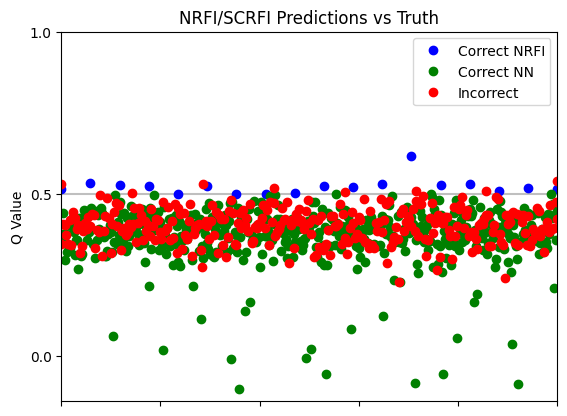

In [ ]:
# prompt: make a plot plotting the four lists defined above, each in different colors with a legend

import matplotlib.pyplot as plt

x = [0, 1]
x_labels = ['NRFI', 'SCRFI']
y_labels = ['NRFI', 'SCRFI']
y_data = [c_nrfi_l, c_nn_l, w_nrfi_l, w_nn_l]
colors = ['red', 'blue', 'orange', 'green']
labels = ['NRFI Guess - NRFI Truth', 'SCRFI Guess - NRFI Truth', 'NRFI Guess - SCRFI Truth', 'SCRFI Guess - SCRFI Truth']

fig, ax = plt.subplots()

# for i in range(len(y_data)):
#   ax.plot(x, y_data[i], color=colors[i], label=labels[i])
ax.plot([0,1],[.5,.5], color = 'gray', alpha = .5)
ax.plot(np.linspace(0,1,len(c_nrfi_l)), c_nrfi_l, 'o', color = 'blue', label = 'Correct NRFI')
ax.plot(np.linspace(0,1,len(c_nn_l)), c_nn_l, 'o', color = 'green', label = 'Correct NN')
ax.plot(np.linspace(0,1,len(w_nn_l)), w_nn_l, 'o', color = 'red', label = 'Incorrect')
ax.plot(np.linspace(0,1,len(w_nrfi_l)), w_nrfi_l, 'o', color = 'red')#, label = 'Incorrect')


print(max(c_nrfi_l))
# ax.set_xticks(x)
ax.set_xticklabels([])
ax.set_yticks([0, .5, 1])
ax.set_xlim(0,1)
ax.set_ylabel('Q Value')
ax.set_title('NRFI/SCRFI Predictions vs Truth')
ax.legend()

plt.show()


(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   3.,  18.,  64., 117.,  76.,  20.,   3.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([-0.5       , -0.44871795, -0.3974359 , -0.34615385, -0.29487179,
        -0.24358974, -0.19230769, -0.14102564, -0.08974359, -0.03846154,
         0.01282051,  0.06410256,  0.11538462,  0.16666667,  0.21794872,
         0.26923077,  0.32051282,  0.37179487,  0.42307692,  0.47435897,
         0.52564103,  0.57692308,  0.62820513,  0.67948718,  0.73076923,
         0.78205128,  0.83333333,  0.88461538,  0.93589744,  0.98717949,
         1.03846154,  1.08974359,  1.14102564,  1.19230769,  1.24358974,
         1.29487179,  1.34615385,  1.3974359 ,  1.44871795,  1.5       ]),
 <BarContainer object of 39 artists>)

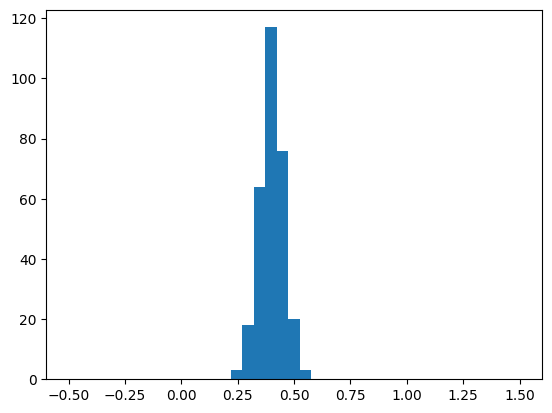

In [ ]:
plt.hist(w_nn_l+w_nrfi_l, bins = np.linspace(-.5,1.5,40))

In [ ]:
gg = [268,	1154,	4.71,	283,	60,	10,	148,	139,	38,	84,	0,	8,	286,	0.271,	0.326,	0.457,	0.336,	4,	19,	4.5,	4,	1,	0,	3,	2,	0,	3,	0,	0,	4,	0.25,	0.368,	0.313,	0.316,	325,	326,	302,	83,	60,	17,	3,	3,	47,	3,	22,	0,	42,	2,	0,	0,	0,	6,	4,	0.274834437,	139,	139,	126,	25,	18,	3,	0,	4,	16,	18,	8,	0,	26,	3,	1,	1,	1,	7,	1,	0.198412698,	1026,	1026,	909,	242,	127,	58,	3,	54,	145,	150,	91,	1,	144,	12,	10,	4,	16,	39,	10,	0.266226622,	189,	189,	169,	50,	37,	7,	0,	6,	20,	39,	15,	0,	30,	2,	3,	0,	6,	3,	0,	0.295857988,	45,	45,	40,	6,	4,	2,	0,	0,	3,	0,	2,	0,	9,	3,	0,	0,	0,	0,	1,	0.15,	23,	23,	21,	5,	3,	1,	1,	0,	1,	4,	1,	0,	3,	1,	0,	0,	0,	2,	0,	0.238095238,	48,	48,	41,	6,	2,	2,	0,	2,	4,	4,	7,	0,	14,	0,	0,	0,	0,	1,	0,	0.146341463,	26,	26,	24,	6,	3,	1,	0,	2,	3,	6,	1,	0,	5,	1,	0,	0,	1,	0,	1,	0.25,	648,	648,	585,	151,	102,	28,	2,	19,	55,	58,	59,	0,	112,	3,	1,	0,	22,	6,	4,	0.258119658,	58,	58,	51,	13,	5,	6,	1,	1,	7,	7,	6,	0,	14,	0,	1,	0,	0,	1,	0,	0.25490196,	29,	29,	26,	1,	1,	0,	0,	0,	0,	2,	2,	0,	4,	0,	1,	0,	0,	0,	0,	0.038461538,	373,	374,	351,	97,	58,	18,	1,	20,	63,	22,	22,	0,	73,	0,	0,	0,	1,	7,	3,	0.276353276	]
print('pitch: ',pitch_data.iloc[:, 3:-1].columns)
print(bat_data.iloc[:, 3:-1].columns)
print(['G', 'TBF', 'ERA', 'H', '2B', '3B', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'SO', 'AVG', 'OBP', 'SLG', 'wOBA'])
print(['G', 'PA', 'AB', 'H', '1B', '2B', '3B', 'HR', 'R', 'RBI', 'BB', 'IBB',
       'SO', 'HBP', 'SF', 'SH', 'GDP', 'SB', 'CS', 'AVG'])

pitch:  Index(['G', 'TBF', 'ERA', 'H', '2B', '3B', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP',
       'SO', 'AVG', 'OBP', 'SLG', 'wOBA'],
      dtype='object')
Index(['G', 'PA', 'AB', 'H', '1B', '2B', '3B', 'HR', 'R', 'RBI', 'BB', 'IBB',
       'SO', 'HBP', 'SF', 'SH', 'GDP', 'SB', 'CS', 'AVG'],
      dtype='object')
['G', 'TBF', 'ERA', 'H', '2B', '3B', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'SO', 'AVG', 'OBP', 'SLG', 'wOBA']
['G', 'PA', 'AB', 'H', '1B', '2B', '3B', 'HR', 'R', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SF', 'SH', 'GDP', 'SB', 'CS', 'AVG']


In [ ]:
     #['G', 'TBF','ERA','H', '2B','3B','R','ER','HR''BB''IBB''HBP','SO', 'AVG', 'OBP', 'SLG', 'wOBA']['G','TBF','ERA''H''2B','3B','R''ER''HR''BB''IBB''HBP''SO''AVG''OBP', 'SLG', 'wOBA']
# gg = [268,	1154,	4.71,	283,	60,	10,	148,	139,	38,	84,	0,	8,	286,	0.271,	0.326,	0.457,	0.336,	4,	19,	4.5,	4,	1,	0,	3,	2,	0,	3,	0,	0,	4,	0.25,	0.368,	0.313,	0.316,	325,	326,	302,	83,	60,	17,	3,	3,	47,	3,	22,	0,	42,	2,	0,	0,	0,	6,	4,	0.274834437,	139,	139,	126,	25,	18,	3,	0,	4,	16,	18,	8,	0,	26,	3,	1,	1,	1,	7,	1,	0.198412698,	1026,	1026,	909,	242,	127,	58,	3,	54,	145,	150,	91,	1,	144,	12,	10,	4,	16,	39,	10,	0.266226622,	189,	189,	169,	50,	37,	7,	0,	6,	20,	39,	15,	0,	30,	2,	3,	0,	6,	3,	0,	0.295857988,	45,	45,	40,	6,	4,	2,	0,	0,	3,	0,	2,	0,	9,	3,	0,	0,	0,	0,	1,	0.15,	23,	23,	21,	5,	3,	1,	1,	0,	1,	4,	1,	0,	3,	1,	0,	0,	0,	2,	0,	0.238095238,	48,	48,	41,	6,	2,	2,	0,	2,	4,	4,	7,	0,	14,	0,	0,	0,	0,	1,	0,	0.146341463,	26,	26,	24,	6,	3,	1,	0,	2,	3,	6,	1,	0,	5,	1,	0,	0,	1,	0,	1,	0.25,	648,	648,	585,	151,	102,	28,	2,	19,	55,	58,	59,	0,	112,	3,	1,	0,	22,	6,	4,	0.258119658,	58,	58,	51,	13,	5,	6,	1,	1,	7,	7,	6,	0,	14,	0,	1,	0,	0,	1,	0,	0.25490196,	29,	29,	26,	1,	1,	0,	0,	0,	0,	2,	2,	0,	4,	0,	1,	0,	0,	0,	0,	0.038461538,	373,	374,	351,	97,	58,	18,	1,	20,	63,	22,	22,	0,	73,	0,	0,	0,	1,	7,	3,	0.276353276	]
# gg2 = [268,	1154,	4.71,	283,	60,	10,	148,	139,	38,	84,	0,	8,	286,	0.271,	0.326,	0.457,	0.336,	4,	19,	4.5,	4,	1,	0,	3,	2,	0,	3,	0,	0,	4,	0.25,	0.368,	0.313,	0.316,	325,	326,	302,	83,	60,	17,	3,	3,	47,	3,	22,	0,	42,	2,	0,	0,	0,	6,	4,	0.274834437,	139,	139,	126,	25,	18,	3,	0,	4,	16,	18,	8,	0,	26,	3,	1,	1,	1,	7,	1,	0.198412698,	1026,	1026,	909,	242,	127,	58,	3,	54,	145,	150,	91,	1,	144,	12,	10,	4,	16,	39,	10,	0.266226622,	189,	189,	169,	50,	37,	7,	0,	6,	20,	39,	15,	0,	30,	2,	3,	0,	6,	3,	0,	0.295857988,	45,	45,	40,	6,	4,	2,	0,	0,	3,	0,	2,	0,	9,	3,	0,	0,	0,	0,	1,	0.15,	23,	23,	21,	5,	3,	1,	1,	0,	1,	4,	1,	0,	3,	1,	0,	0,	0,	2,	0,	0.238095238,	48,	48,	41,	6,	2,	2,	0,	2,	4,	4,	7,	0,	14,	0,	0,	0,	0,	1,	0,	0.146341463,	26,	26,	24,	6,	3,	1,	0,	2,	3,	6,	1,	0,	5,	1,	0,	0,	1,	0,	1,	0.25,	648,	648,	585,	151,	102,	28,	2,	19,	55,	58,	59,	0,	112,	3,	1,	0,	22,	6,	4,	0.258119658,	58,	58,	51,	13,	5,	6,	1,	1,	7,	7,	6,	0,	14,	0,	1,	0,	0,	1,	0,	0.25490196,	29,	29,	26,	1,	1,	0,	0,	0,	0,	2,	2,	0,	4,	0,	1,	0,	0,	0,	0,	0.038461538,	373,	374,	351,	97,	58,	18,	1,	20,	63,	22,	22,	0,	73,	0,	0,	0,	1,	7,	3,	0.276353276	]
# gg = [1154,	4.71,	283,	60,	10,	148,	139,	38,	84,	0,	8,	286,	0.271,	0.326,	0.457,	0.336,		19,	4.5,	4,	1,	0,	3,	2,	0,	3,	0,	0,	4,	0.25,	0.368,	0.313,	0.316,		326,	302,	83,	60,	17,	3,	3,	47,	3,	22,	0,	42,	2,	0,	0,	0,	6,	4,	0.274834437,		139,	126,	25,	18,	3,	0,	4,	16,	18,	8,	0,	26,	3,	1,	1,	1,	7,	1,	0.198412698,		1026,	909,	242,	127,	58,	3,	54,	145,	150,	91,	1,	144,	12,	10,	4,	16,	39,	10,	0.266226622,		189,	169,	50,	37,	7,	0,	6,	20,	39,	15,	0,	30,	2,	3,	0,	6,	3,	0,	0.295857988,		45,	40,	6,	4,	2,	0,	0,	3,	0,	2,	0,	9,	3,	0,	0,	0,	0,	1,	0.15,		23,	21,	5,	3,	1,	1,	0,	1,	4,	1,	0,	3,	1,	0,	0,	0,	2,	0,	0.238095238,		48,	41,	6,	2,	2,	0,	2,	4,	4,	7,	0,	14,	0,	0,	0,	0,	1,	0,	0.146341463,		26,	24,	6,	3,	1,	0,	2,	3,	6,	1,	0,	5,	1,	0,	0,	1,	0,	1,	0.25,		648,	585,	151,	102,	28,	2,	19,	55,	58,	59,	0,	112,	3,	1,	0,	22,	6,	4,	0.258119658,		58,	51,	13,	5,	6,	1,	1,	7,	7,	6,	0,	14,	0,	1,	0,	0,	1,	0,	0.25490196,		29,	26,	1,	1,	0,	0,	0,	0,	2,	2,	0,	4,	0,	1,	0,	0,	0,	0,	0.038461538,		374,	351,	97,	58,	18,	1,	20,	63,	22,	22,	0,	73,	0,	0,	0,	1,	7,	3,	0.276353276]
# gg2 = [1154,	4.71,	283,	60,	10,	148,	139,	38,	84,	0,	8,	286,	0.271,	0.326,	0.457,	0.336,		19,	4.5,	4,	1,	0,	3,	2,	0,	3,	0,	0,	4,	0.25,	0.368,	0.313,	0.316,		326,	302,	83,	60,	17,	3,	3,	47,	3,	22,	0,	42,	2,	0,	0,	0,	6,	4,	0.274834437,		139,	126,	25,	18,	3,	0,	4,	16,	18,	8,	0,	26,	3,	1,	1,	1,	7,	1,	0.198412698,		1026,	909,	242,	127,	58,	3,	54,	145,	150,	91,	1,	144,	12,	10,	4,	16,	39,	10,	0.266226622,		189,	169,	50,	37,	7,	0,	6,	20,	39,	15,	0,	30,	2,	3,	0,	6,	3,	0,	0.295857988,		45,	40,	6,	4,	2,	0,	0,	3,	0,	2,	0,	9,	3,	0,	0,	0,	0,	1,	0.15,		23,	21,	5,	3,	1,	1,	0,	1,	4,	1,	0,	3,	1,	0,	0,	0,	2,	0,	0.238095238,		48,	41,	6,	2,	2,	0,	2,	4,	4,	7,	0,	14,	0,	0,	0,	0,	1,	0,	0.146341463,		26,	24,	6,	3,	1,	0,	2,	3,	6,	1,	0,	5,	1,	0,	0,	1,	0,	1,	0.25,		648,	585,	151,	102,	28,	2,	19,	55,	58,	59,	0,	112,	3,	1,	0,	22,	6,	4,	0.258119658,		58,	51,	13,	5,	6,	1,	1,	7,	7,	6,	0,	14,	0,	1,	0,	0,	1,	0,	0.25490196,		29,	26,	1,	1,	0,	0,	0,	0,	2,	2,	0,	4,	0,	1,	0,	0,	0,	0,	0.038461538,		374,	351,	97,	58,	18,	1,	20,	63,	22,	22,	0,	73,	0,	0,	0,	1,	7,	3,	0.276353276]
gg = [4.71,	283,	60,	10,	148,	139,	38,	84,	0,	8,	286,	0.271,	0.326,	0.457,	0.336,			4.5,	4,	1,	0,	3,	2,	0,	3,	0,	0,	4,	0.25,	0.368,	0.313,	0.316,			302,	83,	60,	17,	3,	3,	47,	3,	22,	0,	42,	2,	0,	0,	0,	6,	4,	0.274834437,			126,	25,	18,	3,	0,	4,	16,	18,	8,	0,	26,	3,	1,	1,	1,	7,	1,	0.198412698,			909,	242,	127,	58,	3,	54,	145,	150,	91,	1,	144,	12,	10,	4,	16,	39,	10,	0.266226622,			169,	50,	37,	7,	0,	6,	20,	39,	15,	0,	30,	2,	3,	0,	6,	3,	0,	0.295857988,			40,	6,	4,	2,	0,	0,	3,	0,	2,	0,	9,	3,	0,	0,	0,	0,	1,	0.15,			21,	5,	3,	1,	1,	0,	1,	4,	1,	0,	3,	1,	0,	0,	0,	2,	0,	0.238095238,			41,	6,	2,	2,	0,	2,	4,	4,	7,	0,	14,	0,	0,	0,	0,	1,	0,	0.146341463,			24,	6,	3,	1,	0,	2,	3,	6,	1,	0,	5,	1,	0,	0,	1,	0,	1,	0.25,			585,	151,	102,	28,	2,	19,	55,	58,	59,	0,	112,	3,	1,	0,	22,	6,	4,	0.258119658,			51,	13,	5,	6,	1,	1,	7,	7,	6,	0,	14,	0,	1,	0,	0,	1,	0,	0.25490196,			26,	1,	1,	0,	0,	0,	0,	2,	2,	0,	4,	0,	1,	0,	0,	0,	0,	0.038461538,			351,	97,	58,	18,	1,	20,	63,	22,	22,	0,	73,	0,	0,	0,	1,	7,	3,	0.276353276]

with torch.no_grad():
    x = torch.tensor(gg)
    x = x.float()
    output1 = net(x.view(1,num_features))
    print(output1.item())
    # print(np.sqrt(2))
    # x = torch.tensor(gg2)
    # x = x.float()
    # output2 = net(x.view(1,num_features))
    # print(output2.item())

-33.95048522949219


With game included in state, no normalization, the incorrectly trending features for the pitchers are:

Home: ER, SO, SLG
Away: H, R, BB, SO, AVG, SLG


With gamese excluded, TBF had too much weight


In [ ]:
with torch.no_grad():
    # for data in test_dataloader:
    x = torch.tensor(gg)
    x = x.float()
    # y = y.float()
    # true_batch_size = len(y)
    output1 = net(x.view(1,num_features))
    print(output1)
    x = torch.tensor(gg)
    x = x.float()
    # y = y.float()
    # true_batch_size = len(y)
    output1 = net(x.view(1,num_features))
    print(output1)
        # for i in range(len(y)):
        #     if y[i].item() == round(output[i].item()):
        #       correct +=1
        #       if y[i].item()==1:
        #         c_nrfi +=1
        #         c_nrfi_l.append(output[i].item())
        #       else:
        #         c_nn +=1
        #         c_nn_l.append(output[i].item())
        #     else:
        #       if y[i].item()==1:
        #         w_nrfi +=1
        #         w_nrfi_l.append(output[i].item())
        #       else:
        #         w_nn +=1
        #         w_nn_l.append(output[i].item())
        #     total+=1

tensor([[-33.9505]])
tensor([[-33.9505]])


In [ ]:
class Test_Game:
  def __init__(self, pitchers_HA, batters_HA, team_at_team_str):
    self.pitch = pitchers_HA
    self.bat = batters_HA
    self.game_name = team_at_team_str
    self.game_input = []

  def build_state(self):
    for pitcher in self.pitch:
      pitcher_names = [pitcher, pitcher + ' Jr.', pitcher + ' II', pitcher + ' III', ]
      pitch_data_row = pitch_data[pitch_data['Name'].isin(pitcher_names)]
      if pitch_data_row.empty:
        print(f'Error: No data found for pitcher {pitcher}. Skipping...')
      pitch_data_row = pitch_data_row.iloc[:, 5:-1]
      val = 0
      for i in pitch_data_row:
        self.game_input.append((pitch_data_row[i].sum() / len(pitch_data_row)))# / max_pitch_values[val])
        val +=1
    for batter in self.bat:
      batter_names = [batter, batter + ' Jr.', batter + ' II', batter + ' III', ]
      bat_data_row = bat_data[bat_data['Name'].isin(batter_names)]#bat_data['Name'],batter)]
      if bat_data_row.empty:
        print(f'Error: No data found for batter {batter}. Skipping...')
      bat_data_row = bat_data_row.iloc[:, 5:-1]
      col = 0
      val = 0
      for i in bat_data_row:
        col+=1
        self.game_input.append((bat_data_row[i].sum() / len(bat_data_row)))# / max_bat_values[val])
        val += 1


  def calc_nrfi(self, network):
    with torch.no_grad():
      x = torch.tensor(self.game_input)
      x = x.float()
      output1 = network(x.view(1,num_features))
      print(self.game_name, ': ', output1.item(), ' NRFI score')

In [ ]:
# Guards at Royals
#
pitchers_HA = ['Seth Lugo', 'Logan Allen']
batters_H = ['Maikel Garcia', 'Bobby Witt Jr.', 'Vinnie Pasquantino', 'Salvador Perez', 'Hunter Renfroe', 'Nick Loftin']
batters_A = ['Steven Kwan', 'Daniel Schneemann', 'Jose Ramirez', 'Josh Naylor', 'Jhonkensy Noel', 'Andres Gimenez']

batters_HA = batters_H + batters_A

game = Test_Game(pitchers_HA, batters_HA, 'Guards at Royals')
game.build_state()
game.calc_nrfi(net)

Error: No data found for batter Jhonkensy Noel. Skipping...
Guards at Royals :  nan  NRFI score


<ipython-input-85-40340370e9a6>:29: RuntimeWarning: invalid value encountered in scalar divide
  self.game_input.append((bat_data_row[i].sum() / len(bat_data_row)))# / max_bat_values[val])


In [ ]:
#Marlins at Phillies

pitchers_HA = ['Ranger Suarez', 'Yonny Chirinos']
batters_H = ['Bryson Stott', 'Trea Turner', 'Alec Bohm', 'Brandon Marsh', 'Nick Castellanos', 'Kody Clemens']
batters_A = ['Jazz Chisholm Jr.', 'Otto Lopez', 'Bryan De La Cruz', 'Josh Bell', 'Jake Burger',  'Dane Myers']

batters_HA = batters_H + batters_A

batters_HA = batters_H + batters_A
game = Test_Game(pitchers_HA, batters_HA, 'Marlins at Phillies')
game.build_state()
game.calc_nrfi(net)

Marlins at Phillies :  19.632783889770508  NRFI score


In [ ]:
#Astros at Mets

pitchers_HA = ['Luis Severino', 'Shawn Dubin']
batters_H = ['Francisco Lindor', 'Brandon Nimmo', 'J.D. Martinez', 'Pete Alonso', 'DJ Stewart', 'Mark Vientos']
batters_A = ['Jose Altuve', 'Alex Bregman', 'Yordan Alvarez', 'Yainer Diaz', 'Jake Meyers', 'Jon Singleton']

batters_HA = batters_H + batters_A

batters_HA = batters_H + batters_A
game = Test_Game(pitchers_HA, batters_HA, 'Astros at Mets')
game.build_state()
game.calc_nrfi(net)

Astros at Mets :  13.908802032470703  NRFI score


In [ ]:
#Reds at Cardinals

pitchers_HA = ['Lance Lynn', 'Hunter Greene']
batters_H = ['Masyn Winn', 'Alec Burleson', 'Willson Contreras', 'Paul Goldschmidt', 'Brendan Donovan', 'Nolan Arenado']
batters_A = ['Jonathan India', 'Elly De La Cruz', 'Jeimer Candelario', 'Spencer Steer', 'Jake Fraley', 'Noelvi Marte']

batters_HA = batters_H + batters_A

batters_HA = batters_H + batters_A
game = Test_Game(pitchers_HA, batters_HA, 'Reds at Cardinals')
game.build_state()
game.calc_nrfi(net)

Reds at Cardinals :  -2.2923011779785156  NRFI score


In [ ]:
#Tigers at Angles

pitchers_HA = ['Tyler Anderson', 'Casey Mize']
batters_H = ['Nolan Schanuel', 'Luis Rengifo', 'Taylor Ward', 'Willie Calhoun', 'Miguel Sano', 'Logan O\'Hoppe']
batters_A = ['Matt Vierling', 'Andy Ibanez', 'Mark Canha', 'Riley Greene', 'Gio Urshela', 'Wenceel Perez']

batters_HA = batters_H + batters_A

batters_HA = batters_H + batters_A
game = Test_Game(pitchers_HA, batters_HA, 'Tigers at Angles')
game.build_state()
game.calc_nrfi(net)
# print(game.game_i)

Tigers at Angles :  -4.288339614868164  NRFI score


In [ ]:
#A's at Diamondbacks

pitchers_HA = ['Tyler Anderson', 'Luis Medina']
batters_H = ['Corbin Carroll', 'Ketel Marte', 'Joc Pederson', 'Christian Walker', 'Lourdes Gurriel Jr.', 'Jake McCarthy']
batters_A = ['JJ Bleday', 'Miguel Andujar', 'Brent Rooker', 'Tyler Soderstrom', 'Kyle McCann', 'Tyler Nevin']

batters_HA = batters_H + batters_A

batters_HA = batters_H + batters_A
game = Test_Game(pitchers_HA, batters_HA, 'A\'s at Diamondbacks')
game.build_state()
game.calc_nrfi(net)
# print(game.game_i)

A's at Diamondbacks :  4.391776084899902  NRFI score


In [ ]:
#Twins at Mariners

pitchers_HA = ['Luis Castillo', 'Joe Ryan']
batters_H = ['J.P. Crawford', 'Josh Rojas', 'Julio Rodriguez', 'Cal Raleigh', 'Luke Raley', 'Mitch Garver']
batters_A = ['Willi Castro', 'Jose Miranda', 'Trevor Larnach', 'Royce Lewis', 'Carlos Santana', 'Byron Buxton']

batters_HA = batters_H + batters_A

batters_HA = batters_H + batters_A
game = Test_Game(pitchers_HA, batters_HA, 'Twins at Mariners')
game.build_state()
game.calc_nrfi(net)
# print(game.game_i)

Twins at Mariners :  5.79992151260376  NRFI score


In [ ]:
game_input = []
for pitcher in pitchers_HA:
  pitcher_names = [pitcher, pitcher + ' Jr.', pitcher + ' II', pitcher + ' III', ]
  pitch_data_row = pitch_data[pitch_data['Name'].isin(pitcher_names)]
  if pitch_data_row.empty:
    print(f'Error: No data found for pitcher {pitcher}. Skipping...')
  pitch_data_row = pitch_data_row.iloc[:, 5:-1]
  val = 0
  for i in pitch_data_row:
    game_input.append((pitch_data_row[i].sum() / len(pitch_data_row)))# / max_pitch_values[val])
    val +=1
for batter in batters_HA:
  batter_names = [batter, batter + ' Jr.', batter + ' II', batter + ' III', ]
  bat_data_row = bat_data[bat_data['Name'].isin(batter_names)]#bat_data['Name'],batter)]
  if bat_data_row.empty:
    print(f'Error: No data found for batter {batter}. Skipping...')
  bat_data_row = bat_data_row.iloc[:, 5:-1]
  col = 0
  val = 0
  for i in bat_data_row:
    col+=1
    game_input.append((bat_data_row[i].sum() / len(bat_data_row)))# / max_bat_values[val])
    val += 1


In [ ]:
print(len(game_input))

with torch.no_grad():
    x = torch.tensor(game_input)
    x = x.float()
    output1 = net(x.view(1,num_features))
    print(output1)


246
tensor([[0.2590]])
